<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/12.%20RNN%20Sequence%20Labeling/%2012_05~07_ner_using_bilstm_cnn_crf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

순서

# 12-05
출처: https://wikidocs.net/147219
1. 개체명 인식 데이터에 대한 이해와 전처리

# 12-07
1. 문자 임베딩(Char Embedding)을 위한 전처리

char 정보를 사용하기 위한 추가 전처리


# 12-05
2. 양방향 LSTM을 이용한 개체명 인식
3. F1-score - 스킵
4. F1-score로 성능 측정하기

#12-06 
1.2.3. BiLSTM-CRF를 이용한 개체명 인식

# 12-07
2. BiLSTM-CNN을 이용한 개체명 인식
3. BiLSTM-CNN-CRF
4. BiLSTM-BiLSTM-CRF


-------

### '양방향 LSTM에 문자 임베딩을 사용한 모델' OR 양방향 LSTM에 CRF 층을 추가적으로 사용한 모델이 

### 단순 '양방향 LSTM만을 사용한 모델' 보다는 성능이 더 좋은 것을 확인

# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

출처: https://wikidocs.net/147219

In [ ]:
import tensorflow as tf
tf.__version__
     

'2.11.0'

In [ ]:
!pip install keras-crf==0.3.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [ ]:
# 모델 평가
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=e58f8d71e266896eaac0d36831f235509ed4b1d97984c7c04ff11031608c2511
  Stored in directory: /root/.cache/pip/wheels/ad/5c/ba/05fa33fa5855777b7d686e843ec07452f22a66a138e290e732
Successfully built seqeval


In [ ]:
!pip list | grep keras-crf


keras-crf                     0.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)
# 1. 개체명 인식 데이터에 대한 이해와 전처리

출처: https://wikidocs.net/147219


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
     

In [ ]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ner_dataset.csv", encoding="latin1")


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ner_dataset.csv", encoding="latin1")


In [ ]:
data[:5]


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


 첫번째 열 'Sentence :#'은 다음과 같은 패턴을 가지고 있습니다. Sentence: 1이 등장하고 Null 값이 이어지다가 다시 Sentence: 2가 등장하고 다시 Null 값이 이어지다가 Sentence: 3이 등장하고 다시 Null 값이 이어지다가를 반복합니다. 사실 이는 하나의 문장을 여러 행으로 나눠놓은 것입니다. 숫자값을 t라고 합시다. 첫번째 Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 행은 기존에 하나의 문장이었습니다. t번째 문장을 단어 토큰화 후 각 행으로 나눠놓은 데이터이기 때문입니다. 뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 해줍니다.

In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))


데이터프레임 행의 개수 : 1048575


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))


데이터에 Null 값이 있는지 유무 : True


In [ ]:

print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()
     

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

 전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 셀 수 있게 해주는 nunique()를 사용

In [ ]:

print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


* 이 데이터에는 47,959개의 문장이 있으며 문장들은 35,178개의 단어를 가지고 17개 종류의 개체명 태깅을 가집니다. 

* 17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인

In [ ]:

print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


 데이터를 원하는 형태로 가공해보겠습니다. 우선 Null 값을 제거합니다. Pandas의 fillna(method='ffill')는 Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업을 수행합니다. t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫번째 열에 Sentence: t의 값이 들어갑니다. 이번에는 뒤의 5개의 샘플을 출력해서 정상적으로 수행되었는지 확인

In [ ]:
data = data.fillna(method="ffill")


In [ ]:
print(data.tail())


              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))


데이터에 Null 값이 있는지 유무 : False


모든 단어를 소문자화하여 단어의 개수를 줄여보겠습니다.

In [ ]:

data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])


    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


# 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업을 수행합니다.

In [ ]:

func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


1,000,616개의 행의 개수가 각 문장당 하나의 샘플로 묶이면서 47,959개의 샘플이 되었습니다. 정상적으로 수행되었는지 첫번째 샘플을 출력

In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력


[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리

즉, [('thousands', 'O'), ('of', 'O')]와 같은 문장 샘플이 있다면 thousands와 of는 같이 저장하고, O와 O를 같이 저장할 필요가 있습니다. 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 하는 zip()을 사용하여 단어와 개체명 태깅 정보를 분리

In [ ]:

sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:

print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


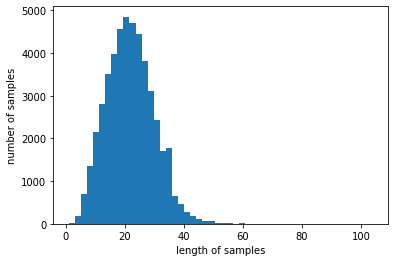

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 104입니다. 

## 케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하겠습니다.

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

### 문장 데이터에 대해서는 src_tokenizer

### 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))
     

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택했습니다. 인덱스1에 단어 'OOV'가 할당*

In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))


단어 OOV의 인덱스 : 1


# 정수 인코딩을 수행

In [ ]:

X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


### 모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word

### 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner

 인덱스 0은 'PAD'란 단어를 할당

  index_to_ner은 개수가 적으니 출력

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)


{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


### index_to_word를 통해 첫번째 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩 작업을 해보겠습니다.

In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


### 1. 데이터의 길이는 40~60에 분포되어져 있습니다. 그러므로 가장 긴 샘플의 길이인 104가 아니라 70정도로 max_len을 정해보겠습니다

### 2. 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리

In [ ]:

max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)


 원-핫 인코딩을 수행

In [ ]:

y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))
     

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


# 12-07 문자 임베딩(Character Embedding) 활용하기

# 1. 문자 임베딩(Char Embedding)을 위한 전처리


# char 정보를 사용하기 위한 추가 전처리

출처 : https://wikidocs.net/147299

문자 임베딩을 위해서 하고자 하는 전처리는 문자 단위 정수 인코딩

가령 단어 'book'이 있고, b가 21번 o가 7번, k가 11번이라고 한다면 단어 'book'을 [21 7 7 11]로 인코딩

'good book'이란 문장이 있고, g가 12번, d가 17번이라고 한다면 이 문장을 문자 단위 정수 인코딩 후에는 다음과 같은 결과를 얻을 수 있습니다.

'good book의 정수 인코딩 결과'

[[12 7 7 17]

[21 7 7 11]]

이 각 문자와 맵핑된 정수를 각각 임베딩 층(Embedding layer)을 거치도록 하여, 문자 단위 임베딩

문자에 대한 정수 인코딩을 진행

. 우선 전체 데이터의 모든 단어를 문자 레벨로 분해하여, 문자 집합





# char_vocab 만들기


In [ ]:

# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


이렇게 얻은 문자 집합으로부터 문자를 정수로 변환할 수 있는 딕셔너리인 

# char_to_index와 반대로 정수로부터 문자를 얻을 수 있는 

# 딕셔너리인 index_to_char를 만듭니다.

In [ ]:

char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [ ]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key
     

단어를 표현하는 문자 시퀀스의 최대 길이는 15로 제한 후 패딩

In [ ]:
print(sentences[0])


['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:

max_len_char = 15

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]  
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

In [ ]:
X_char_data = integer_coding(sentences)


동일한 문장에 대해서 단어 단위 정수 인코딩과 문자 단위 정수 인코딩의 차이를 확인해봅시다. 첫번째 샘플은 다음과 같습니다.

In [ ]:

# 정수 인코딩 이전의 기존 문장
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


위 문장을 정수 인코딩 및 패딩한 결과는 다음과 같습니다.



In [ ]:
print(X_data[0])


[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


### 254는 기존의 thousands, 6은 기존의 of에 해당됩니다. 해당 샘플을 문자 단위 정수 인코딩한 결과는 다음과 같습니다.

In [ ]:
print(X_char_data[0])


[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0  0  0  0  0  0

# 위 출력 결과에서 각 행은 각 단어를 의미합니다. 가령, thousands는 첫번째 행 [53 41 48 54 52 34 47 37 52 0 0 0 0 0 0]에 해당됩니다. 단어의 최대 길이를 15(max_len_char)로 제한하였으므로, 길이가 15보다 짧은 단어는 뒤에 0으로 패딩됩니다.

# 53은 t, 41은 h, 48은 o, 54는 u에 각각 해당됩니다. X_data는 뒤에 0으로 패딩되어 길이가 70인 것에 비해 X_char_data는 현재 0번 단어는 무시되어 길이가 70이 아닙니다. 다시 말해 위 출력 결과에서 행의 개수가 70이 아닌 상태입니다. 길이 70으로 맞춰주기 위해서 문장 길이 방향으로도 패딩

In [ ]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)


### 단어 단위 정수 인코딩 결과는 이미 X_train, y_train, X_test, y_test로 훈련 데이터와 테스트 데이터가 분리된 상태입니다. 문자 단위 정수 인코딩 결과에 대해서도 마찬가지로 X_char_train, X_char_test로 나누어줍니

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)


In [ ]:

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [ ]:
print(X_train[0])


[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


첫번째 훈련 샘플의 첫번째 단어인 150번

In [ ]:
print(index_to_word[150])


soldiers


그렇다면 X_char_train의 첫번째 훈련 샘플의 첫번째 단어의 문자 정수 인코딩 결과로부터 soldiers라는 단어와 일치하는지 확인




In [ ]:
print(X_char_train[0])


[[52 48 45 ...  0  0  0]
 [51 38 53 ...  0  0  0]
 [39 42 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
print(X_char_train[0][0])


[52 48 45 37 42 38 51 52  0  0  0  0  0  0  0]


In [ ]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))


s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [ ]:

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM을 이용한 개체명 인식

# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

# 2. 양방향 LSTM을 이용한 개체명 인식

출처: https://wikidocs.net/147219

# 모델링

하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 256

모델: 다 대 다 구조의 양방향 LSTM을 사용

 LSTM의 return_sequences의 인자값은 True

 . 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션을 줄 수 있습니다. 출력층에 TimeDistributed()를 사용했는데, TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

다중 클래스 분류 문제

출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용

하이퍼파라미터인 배치 크기는 128이며, 6 에포크를 수행

. validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리해서 사용

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4072832   
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        788480    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 18)         9234      
 ibuted)                                                         
                                                                 
Total params: 4,870,546
Trainable params: 4,870,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)


Epoch 1/6
270/270 [==============================] - 40s 98ms/step - loss: 0.5480 - accuracy: 0.8790 - val_loss: 0.2406 - val_accuracy: 0.9339
Epoch 2/6
270/270 [==============================] - 9s 35ms/step - loss: 0.1724 - accuracy: 0.9505 - val_loss: 0.1554 - val_accuracy: 0.9540
Epoch 3/6
270/270 [==============================] - 7s 26ms/step - loss: 0.1196 - accuracy: 0.9644 - val_loss: 0.1395 - val_accuracy: 0.9575
Epoch 4/6
270/270 [==============================] - 5s 20ms/step - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.1391 - val_accuracy: 0.9584
Epoch 5/6
270/270 [==============================] - 5s 17ms/step - loss: 0.0844 - accuracy: 0.9733 - val_loss: 0.1397 - val_accuracy: 0.9591
Epoch 6/6
270/270 [==============================] - 5s 17ms/step - loss: 0.0746 - accuracy: 0.9760 - val_loss: 0.1451 - val_accuracy: 0.9574


In [ ]:
model.save('bilstm.h5')


In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


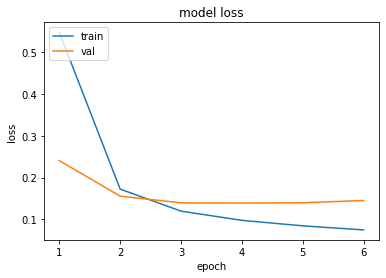

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 12-05 BiLSTM을 이용한 개체명 인식(Named Entity Recognition, NER)

# 4. F1-score로 성능 측정하기

# 출처: https://wikidocs.net/147219

F1-score를 계산하기 위해서 개체명 태깅의 확률 벡터 또는 원-핫 벡터로부터 태깅 정보 시퀀스로 변환하는 함수인 sequences_to_tag를 만듭니다. 

해당 함수를 통해 모델의 예측값인 y_predicted와 실제값에 해당하는 y_test를 태깅 정보 시퀀스로 변환합니다. 그리고 두 개를 비교하여 f1-score를 계산

In [ ]:
from seqeval.metrics import f1_score, classification_report


In [ ]:

def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:

y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

300/300 [==============================] - 4s 4ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))


              precision    recall  f1-score   support

         art       0.18      0.05      0.07        63
         eve       0.54      0.27      0.36        52
         geo       0.86      0.80      0.83      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.45      0.27      0.34        37
         org       0.54      0.61      0.57      4033
         per       0.72      0.73      0.73      3545
         tim       0.85      0.84      0.85      4067

   micro avg       0.78      0.78      0.78     22562
   macro avg       0.64      0.56      0.59     22562
weighted avg       0.79      0.78      0.78     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


F1-score: 78.0%


어서 CRF 층을 추가하여 성능을 높여봅시다.

# 12-06 BiLSTM-CRF를 이용한 개체명 인식
# 3. BiLSTM-CRF를 이용한 개체명 인식


# BiLSTM-CRF를 이용한 개체명인식
# 모델링

출처: https://wikidocs.net/147234

이전과 동일한 데이터에 대해서 모델을 학습해봅시다. 

## 마지막 층에 CRF 층을 추가하기 위하여 함수형 API를 사용합니다. 

하이퍼파라미터인 임베딩 벡터의 차원은 128, 
은닉 상태의 크기는 64
모델은 다 대 다 구조의 양방향 LSTM을 사용합니다. 

이 경우 LSTM의 return_sequences의 인자값은 True
출력층에 TimeDistributed()를 사용, 
TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

-----

해당 모델은 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 여기서는 최종 출력층이 CRF 층으로 CRF 층에 분류해야 하는 선택지 개수를 의미하는 tag_size를 전달해줍니다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "crf_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 70, 128)      4072832     ['sequence_input[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 70, 128)     98816       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 70, 128)     0           ['bidirectional_1[0][0]']

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
     

하이퍼파라미터인 배치 크기는 128이며, 15 에포크를 수행

validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리해서 사용

검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인

. 조기 종료를 사용하기 위해서 콜백을 정의

## . keras-crf가 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용함을 주의합니다.

In [ ]:
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])


Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9154 - loss: 28.4227
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.96095, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 48s 151ms/step - decode_sequence_accuracy: 0.9154 - loss: 28.3522 - val_decode_sequence_accuracy: 0.9610 - val_loss: 8.9030
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9716 - loss: 6.4258
Epoch 2: val_decode_sequence_accuracy improved from 0.96095 to 0.98080, saving model to bilstm_crf/cp.ckpt
270/270 [==============================] - 29s 108ms/step - decode_sequence_accuracy: 0.9716 - loss: 6.4176 - val_decode_sequence_accuracy: 0.9808 - val_loss: 4.9572
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9831 - loss: 3.7449
Epoch 3: val_decode_sequence_accuracy improved from 0.98080 to 0.98388, saving model to bilstm_crf/cp.ckpt
270/270 [===

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 임의로 선정한 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측해봅시다.

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')


In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 988ms/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다.

In [ ]:
y_predicted = model.predict(X_test)[0]


300/300 [==============================] - 8s 28ms/step


상위 2개만 출력해봅시다.

예측값으로 확률 벡터가 아니라 정수 시퀀스가 출력

 경우 이전 실습에서 사용했던 함수인 sequences_to_tag를 사용할 수 없으므로 함수를 수정해야 합니다. 확률 벡터가 아닌 정수 시퀀스를 입력으로 받아서 태깅 정보 시퀀스를 리턴하는 함수로 sequences_to_tag_for_crf를 만듭니다. 

 해당 함수를 사용하여 예측값과 레이블에 해당하는 y_test를 태깅 정보 시퀀스로 변환하여 F1-score를 계산합니다.



In [ ]:

def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:

def sequences_to_tag_for_crf(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            # pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = pred
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

In [ ]:
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))


/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.00      0.00      0.00        52
         geo       0.81      0.86      0.84      7620
         gpe       0.94      0.93      0.93      3145
         nat       0.00      0.00      0.00        37
         org       0.67      0.55      0.60      4033
         per       0.76      0.70      0.73      3545
         tim       0.85      0.83      0.84      4067

   micro avg       0.81      0.78      0.79     22562
   macro avg       0.50      0.48      0.49     22562
weighted avg       0.80      0.78      0.79     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


F1-score: 79.3%


# 12-07 문자 임베딩(Character Embedding) 활용하기

# 2. BiLSTM-CNN을 이용한 개체명 인식

# 모델링

우선 문자 임베딩이 활용되는 과정

나의 단어는 문자 단위로 토큰화

토큰화 된 각 문자는 위의 전처리를 통해 정수로 맵핑된 상태

### 정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터

이후 1D 합성곱 층의 입력으로 사용

# 1D 합성곱 층의 커널의 크기는 3이며 해당 커널은 총 30개 사용

#  1D 합성곱 층의 결과로 하나의 단어에 대한 단어 벡터

해당 단어 벡터는 일반적으로 워드 임베딩이라고 부르던 과정을 통해 얻은 단어의 임베딩 벡터와 연결(concatenate)



이를 양방향 LSTM의 입력으로 사용하게 되는데, 이후에는 이전 실습들과 같습니다

# *LSTM의 은닉 상태의 크기는 256

모델은 다 대 다 구조의 양방향 LSTM을 사용

이 경우 LSTM의 return_sequences의 인자값은 True

* 출력층에 TimeDistributed()를 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용합니다.







In [ ]:

from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                            

조기 종료를 조건으로 콜백을 정의

이전 실습과 동일한 조건으로 배치 크기는 128로 하고, 15 에포크를 학습

훈련 데이터의 10%를 검증 데이터로 사용

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])


Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.2041 - acc: 0.9488
Epoch 1: val_acc improved from -inf to 0.97759, saving model to bilstm_cnn.h5
270/270 [==============================] - 39s 105ms/step - loss: 0.2041 - acc: 0.9488 - val_loss: 0.0809 - val_acc: 0.9776
Epoch 2/15
270/270 [==============================] - ETA: 0s - loss: 0.0596 - acc: 0.9830
Epoch 2: val_acc improved from 0.97759 to 0.98536, saving model to bilstm_cnn.h5
270/270 [==============================] - 11s 39ms/step - loss: 0.0596 - acc: 0.9830 - val_loss: 0.0498 - val_acc: 0.9854
Epoch 3/15
270/270 [==============================] - ETA: 0s - loss: 0.0417 - acc: 0.9878
Epoch 3: val_acc improved from 0.98536 to 0.98660, saving model to bilstm_cnn.h5
270/270 [==============================] - 9s 34ms/step - loss: 0.0417 - acc: 0.9878 - val_loss: 0.0445 - val_acc: 0.9866
Epoch 4/15
270/270 [==============================] - ETA: 0s - loss: 0.0348 - acc: 0.9895
Epoch 4: val_acc improved f

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러옵니다.

해당 모델에 대해서 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측

In [ ]:
model = load_model('bilstm_cnn.h5')


In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 698ms/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다. 그리고 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 F1-score를 계산합니다.

In [ ]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

300/300 [==============================] - 1s 5ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.79      0.21      0.33        52
         geo       0.81      0.86      0.84      7620
         gpe       0.95      0.94      0.95      3145
         nat       1.00      0.03      0.05        37
         org       0.63      0.54      0.58      4033
         per       0.73      0.72      0.73      3545
         tim       0.85      0.84      0.85      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.72      0.52      0.54     22562
weighted avg       0.79      0.78      0.78     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


F1-score: 79.0%


# 12-07 문자 임베딩(Character Embedding) 활용하기

# 3. BiLSTM-CNN-CRF


# BiLSTM-CNN-CRF를 이용한 개체명인식
# 모델링

출처: https://wikidocs.net/147299
 

# '양방향 LSTM에 문자 임베딩을 사용한 모델' OR 양방향 LSTM에 CRF 층을 추가적으로 사용한 모델이 

# 단순 '양방향 LSTM만을 사용한 모델' 보다는 성능이 더 좋은 것을 확인

 이번에는 문자 임베딩을 사용한 위 모델에 CRF 층까지 추가적으로 사용

In [ ]:
import tensorflow as tf
from keras_crf import CRFModel

In [ ]:

embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_3 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
     


CRF 층은 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용함을 주의합니다.

In [1]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])


NameError: ignored

## 조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측해봅시다.

In [ ]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')


In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] 
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 1s 977ms/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


### 정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다. 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 F1-score를 계산합니다

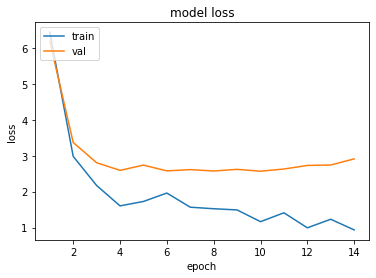

In [ ]:

epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

300/300 [==============================] - 9s 29ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.82      0.17      0.29        52
         geo       0.84      0.85      0.84      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.00      0.00      0.00        37
         org       0.67      0.58      0.62      4033
         per       0.77      0.74      0.75      3545
         tim       0.89      0.83      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.62      0.51      0.54     22562
weighted avg       0.82      0.79      0.80     22562



In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


F1-score: 80.6%


# 12-07 문자 임베딩(Character Embedding) 활용하기

# 4. BiLSTM-BiLSTM-CRF

출처: https://wikidocs.net/147299


# BiLSTM-BiLSTM-CRF을 이용한 개체명 인식
모델링

문자 임베딩이 활용되는 과정

하나의 단어는 문자 단위로 토큰화되었고, 토큰화 된 각 문자는 위의 전처리를 통해 정수로 맵핑된 상태

정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터

이후 양방향 LSTM 입력으로 사용되는데, 이때 사용되는 LSTM의 은닉 상태의 크기는 64

해당 LSTM은 다 대 일(many-to-one)구조로 순방향 LSTM의 은닉 상태와 역방향 LSTM의 은닉 상태가 연결(concatenate)된 값이 양방향 LSTM의 출력

해당 출력을 하나의 단어에 대한 단어 벡터로 간주

해당 단어 벡터는 일반적으로 워드 임베딩이라고 부르던 과정을 통해 얻은 단어의 임베딩 벡터와 연결(concatenate)됩니다.

. 이를 개체명 인식을 위한 양방향 LSTM의 입력으로 사용하게 되는데, 이후에는 이전 실습들과 같습니다. CRF 층은 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train_int를 사용합니다

In [ ]:

embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
word_embeddings = concatenate([word_embeddings, char_embeddings])

word_embeddings = Dropout(dropout_ratio)(word_embeddings)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(word_embeddings)
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 word_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, None, None,   4736        ['char_input[0][0]']             
                                64)                                                               
                                                                                        

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)


In [ ]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])


Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9230 - loss: 20.5625
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.96869, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 53s 163ms/step - decode_sequence_accuracy: 0.9230 - loss: 20.5146 - val_decode_sequence_accuracy: 0.9687 - val_loss: 7.9423
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9766 - loss: 5.4261
Epoch 2: val_decode_sequence_accuracy improved from 0.96869 to 0.98309, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 32s 120ms/step - decode_sequence_accuracy: 0.9766 - loss: 5.4216 - val_decode_sequence_accuracy: 0.9831 - val_loss: 4.0972
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9859 - loss: 3.1328
Epoch 3: val_decode_sequence_accuracy improved from 0.98309 to 0.98598, saving model to bilstm_bilstm_crf

조기 종료로 학습이 끝났다면 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러온 후, 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측합니다.

In [ ]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')


정확하게 잘 예측한 것 같습니다. 테스트 데이터에 대해서 성능을 측정해봅시다. 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻습니다. 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 F1-score를 계산합니다.

In [ ]:

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

1/1 [==============================] - 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


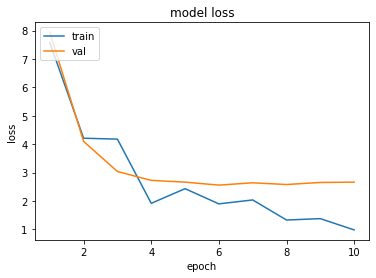

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

300/300 [==============================] - 9s 30ms/step


In [ ]:
print(classification_report(test_tags, pred_tags))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.78      0.13      0.23        52
         geo       0.83      0.86      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.00      0.00      0.00        37
         org       0.69      0.55      0.62      4033
         per       0.78      0.76      0.77      3545
         tim       0.87      0.85      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.61      0.51      0.53     22562
weighted avg       0.82      0.79      0.80     22562



In [ ]:
# 성능

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


F1-score: 81.0%
